# 1. 데이터 준비하기

In [129]:
import pandas
import konlpy
import gensim
from gensim.models import KeyedVectors

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

import os
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

1.3.3
0.5.2
4.1.2


In [2]:
data_path = '/aiffel/aiffel/sentiment_classification/data/'

os.listdir(data_path)

['ratings_train.txt',
 'ratings_test.txt',
 'GoogleNews-vectors-negative300.bin.gz',
 'word2vec.txt']

In [3]:
# 데이터 불러오기
train_data = pd.read_table(os.path.join(data_path, 'ratings_train.txt'))
test_data = pd.read_table(os.path.join(data_path, 'ratings_test.txt'))

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터 전처리, 데이터로더 구성하기

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [5]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
tokenizer = Mecab()
Kkoma()
afsa()


In [7]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# train, test 합쳐서 한번에 진행
df_list = [train_data, test_data]

for i, df in enumerate(df_list):
    # 데이터 중복 제거
    df = df.drop_duplicates(subset=['document'])

    # NaN 결측치 제거
    df = df.dropna()

    # tokenizing
    tokens = []
    for doc in tqdm(df['document']):
        # 형태소 추출
        token = tokenizer.morphs(doc)
        token = [word for word in token if not word in stopwords]
        tokens.append(token)
    df['tokens'] = tokens
    df_list[i] = df
    
train_data = df_list[0]
test_data = df_list[1]

# 사전 만들기(train에서만 만들어야 됨)
words = np.concatenate(train_data['tokens'].values).tolist()
counter = Counter(words)
counter = counter.most_common(10000-4) # 정해져있는 앞에 4개 토큰 빼고 만들기
vocab = ['', '', '', ''] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

X_train = list(map(wordlist_to_indexlist, train_data['tokens'].values))
X_test = list(map(wordlist_to_indexlist, test_data['tokens'].values))

100%|██████████| 49157/49157 [00:04<00:00, 10539.30it/s]


In [69]:
tokenizer = Mecab()
# 필요없는 단어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data():
    # 데이터 불러오기
    data_path = '/aiffel/aiffel/sentiment_classification/data/'

    train_data = pd.read_table(os.path.join(data_path, 'ratings_train.txt'))
    test_data = pd.read_table(os.path.join(data_path, 'ratings_test.txt'))
    
    return train_data, test_data

def preprocessing_data(train_data, test_data, num_words=10000):
    # train, test 합쳐서 한번에 진행
    df_list = [train_data, test_data]

    for i, df in enumerate(df_list):
        # 데이터 중복 제거
        df = df.drop_duplicates(subset=['document'])

        # NaN 결측치 제거
        df = df.dropna()

        # tokenizing
        tokens = []
        for doc in tqdm(df['document']):
            # 형태소 추출
            token = tokenizer.morphs(doc)
            token = [word for word in token if not word in stopwords]
            tokens.append(token)
        df['tokens'] = tokens
        df_list[i] = df

    train_data = df_list[0]
    test_data = df_list[1]

    # 사전 만들기(train에서만 만들어야 됨)
    words = np.concatenate(train_data['tokens'].values).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4) # 정해져있는 앞에 4개 토큰 빼고 만들기
    vocab = ['<PAD>', '<UNK>', '<BOS>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # token을 index로 바꾸기
    X_train = list(map(wordlist_to_indexlist, train_data['tokens'].values))
    X_test = list(map(wordlist_to_indexlist, test_data['tokens'].values))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


# 데이터 불러오기
train_data, test_data = load_data()

X_train, y_train, X_test, y_test, word_to_index = preprocessing_data(train_data, test_data)

100%|██████████| 49157/49157 [00:04<00:00, 10791.04it/s]


In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공

In [11]:
# 학습 셋만을 가지고 분포를 살펴보가.
total_data_text = list(X_train)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 4 * np.std(num_tokens)
maxlen = int(max_tokens)

print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.98170773419436
문장길이 최대 :  116
문장길이 표준편차 :  12.82473766384545
pad_sequences maxlen :  67
전체 문장의 0.9975852020084552%가 maxlen 설정값 이내에 포함됩니다. 


In [64]:
# 4표준편차로 maxlen 설정.0.997정도 포함됨
# padding 추가하기
padded_X_tr = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
padded_X_ts = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [65]:
padded_X_tr

array([[   0,    0,    0, ...,   20,   33,  748],
       [   0,    0,    0, ...,   15,   44,  391],
       [   0,    0,    0, ...,   24,  205,    3],
       ...,
       [   0,    0,    0, ..., 2710,    6,   18],
       [   0,    0,    0, ...,   60,  395, 8572],
       [   0,    0,    0, ...,   88, 2740,    5]], dtype=int32)

In [13]:
np.mean([len(tokens) for tokens in padded_X_tr]), np.mean([len(tokens) for tokens in padded_X_ts])

(67.0, 67.0)

In [70]:
def padding_data(X_train, X_test, max_len=67, padding='pre'):
    
    padded_X_tr = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
    padded_X_ts = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)
    return padded_X_tr, padded_X_ts

# 4. 모델 구성 및 validation set 구성

In [75]:
# 데이터 불러오기
train_data, test_data = load_data()

# 데이터 처리하기
X_train, y_train, X_test, y_test, word_to_index = preprocessing_data(train_data, test_data)

# padding
X_train, X_ts = padding_data(X_train, X_test)

# validation set 나누기
val_ratio = 0.2

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=val_ratio, random_state=2023)
print(f"tr: {X_tr.shape}, val: {X_val.shape}, ts: {X_ts.shape}")

100%|██████████| 49157/49157 [00:04<00:00, 10701.72it/s]


tr: (116945, 67), val: (29237, 67), ts: (49157, 67)


In [39]:
# 모델 만들기 , 총 3개 모델 (Vanila RNN, 1-D CNN, MaxPool1D)

In [81]:
# 1. Vanila RNN
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

simple_RNN = tf.keras.Sequential()
simple_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple_RNN.add(tf.keras.layers.LSTM(10))  # status vector 의 size
simple_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
simple_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

simple_RNN.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                4440      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 1,004,537
Trainable params: 1,004,537
Non-trainable params: 0
_________________________________________________________________


In [47]:
# 2. 1-D CNN
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

OneD_CNN = tf.keras.Sequential()
OneD_CNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
OneD_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
OneD_CNN.add(tf.keras.layers.MaxPooling1D(5))
OneD_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
OneD_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
OneD_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
OneD_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

OneD_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [48]:
# 3. GlobalMaxPooling1D
vocab_size = len(word_to_index)  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 100  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

MaxPool1D = tf.keras.Sequential()
MaxPool1D.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
MaxPool1D.add(tf.keras.layers.GlobalMaxPooling1D())
MaxPool1D.add(tf.keras.layers.Dense(8, activation='relu'))
MaxPool1D.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

MaxPool1D.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


# 5. 모델 훈련 게시

In [82]:
# 1. Vanila RNN
simple_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

rnn_history = simple_RNN.fit(X_tr,
                             y_tr,
                             epochs=epochs,
                             batch_size=512,
                             validation_data=(X_val, y_val),
                             verbose=1)

Epoch 1/20
229/229 [==============================] - 4s 9ms/step - loss: 0.4542 - accuracy: 0.7988 - val_loss: 0.3603 - val_accuracy: 0.8439
Epoch 2/20
229/229 [==============================] - 2s 7ms/step - loss: 0.3293 - accuracy: 0.8625 - val_loss: 0.3425 - val_accuracy: 0.8494
Epoch 3/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2995 - accuracy: 0.8766 - val_loss: 0.3397 - val_accuracy: 0.8508
Epoch 4/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2794 - accuracy: 0.8855 - val_loss: 0.3401 - val_accuracy: 0.8529
Epoch 5/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2603 - accuracy: 0.8939 - val_loss: 0.3510 - val_accuracy: 0.8519
Epoch 6/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2407 - accuracy: 0.9022 - val_loss: 0.3505 - val_accuracy: 0.8511
Epoch 7/20
229/229 [==============================] - 2s 7ms/step - loss: 0.2229 - accuracy: 0.9107 - val_loss: 0.3576 - val_accuracy: 0.8533
Epoch 

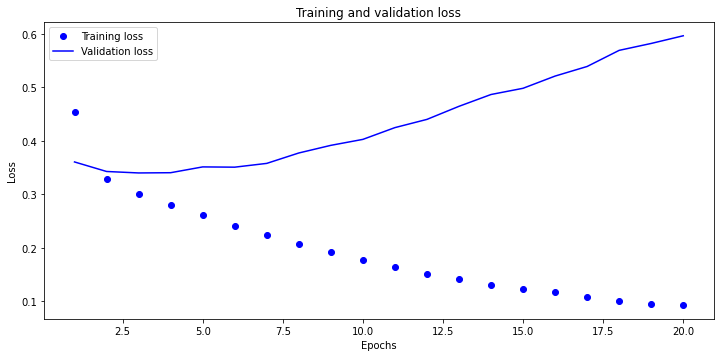

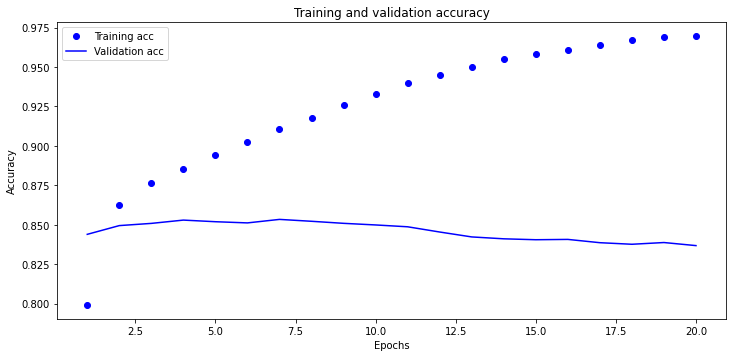

In [91]:
history_dict = rnn_history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# -> 학습이 엉망으로 되고 있다.

In [92]:
# 2. 1-D CNN
OneD_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

CNN_history = OneD_CNN.fit(X_tr,
                             y_tr,
                             epochs=epochs,
                             batch_size=512,
                             validation_data=(X_val, y_val),
                             verbose=1)

Epoch 1/20
229/229 [==============================] - 20s 10ms/step - loss: 0.4893 - accuracy: 0.7516 - val_loss: 0.3652 - val_accuracy: 0.8349
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3275 - accuracy: 0.8589 - val_loss: 0.3487 - val_accuracy: 0.8432
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2793 - accuracy: 0.8834 - val_loss: 0.3518 - val_accuracy: 0.8435
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.2292 - accuracy: 0.9088 - val_loss: 0.3696 - val_accuracy: 0.8430
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1770 - accuracy: 0.9333 - val_loss: 0.4187 - val_accuracy: 0.8395
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.1305 - accuracy: 0.9532 - val_loss: 0.4680 - val_accuracy: 0.8340
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.0944 - accuracy: 0.9675 - val_loss: 0.5321 - val_accuracy: 0.8308
Epoc

In [93]:
# 3. GlobalMaxPooling1D
MaxPool1D.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

MaxPool_history = MaxPool1D.fit(X_tr,
                             y_tr,
                             epochs=epochs,
                             batch_size=512,
                             validation_data=(X_val, y_val),
                             verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 5ms/step - loss: 0.5160 - accuracy: 0.7748 - val_loss: 0.3761 - val_accuracy: 0.8388
Epoch 2/20
229/229 [==============================] - 1s 4ms/step - loss: 0.3309 - accuracy: 0.8618 - val_loss: 0.3437 - val_accuracy: 0.8506
Epoch 3/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2829 - accuracy: 0.8849 - val_loss: 0.3426 - val_accuracy: 0.8528
Epoch 4/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2479 - accuracy: 0.9027 - val_loss: 0.3503 - val_accuracy: 0.8521
Epoch 5/20
229/229 [==============================] - 1s 4ms/step - loss: 0.2148 - accuracy: 0.9182 - val_loss: 0.3641 - val_accuracy: 0.8496
Epoch 6/20
229/229 [==============================] - 1s 4ms/step - loss: 0.1831 - accuracy: 0.9332 - val_loss: 0.3857 - val_accuracy: 0.8483
Epoch 7/20
229/229 [==============================] - 1s 4ms/step - loss: 0.1526 - accuracy: 0.9470 - val_loss: 0.4083 - val_accuracy: 0.8452
Epoch 

In [179]:
# 테스트셋을 통한 모델 평가
results = simple_RNN.evaluate(X_ts,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.6171 - accuracy: 0.8330
[0.6171362996101379, 0.8329840898513794]


In [180]:
# 테스트셋을 통한 모델 평가
results = OneD_CNN.evaluate(X_ts,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.1795 - accuracy: 0.8145
[1.179455041885376, 0.8145126700401306]


In [181]:
# 테스트셋을 통한 모델 평가
results = MaxPool1D.evaluate(X_ts,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.8405 - accuracy: 0.8295
[0.8404644727706909, 0.829505443572998]


# 6. Loss, Accuracy 그래프 시각화

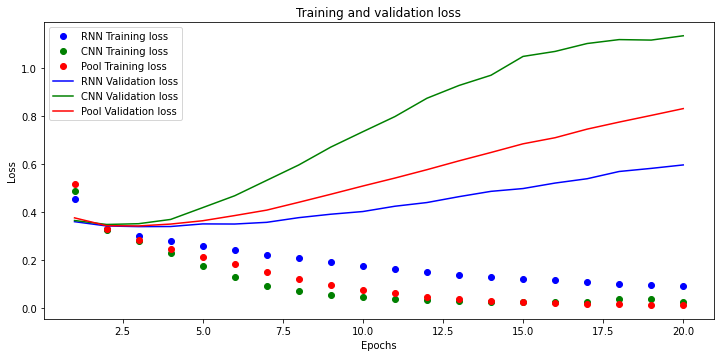

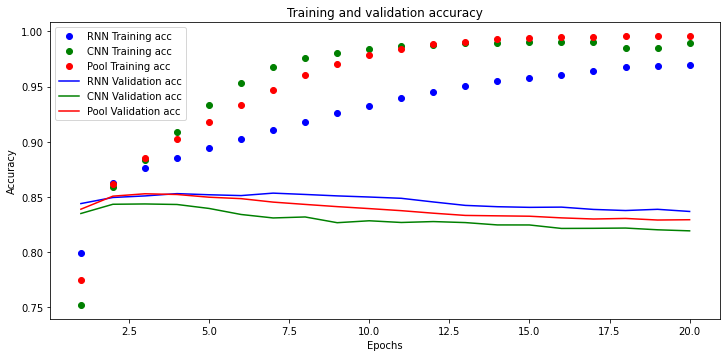

In [108]:
# 결과 3개 한번에 살펴보기
def get_acc_loss(history):
    history_dict = history.history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    return acc, val_acc, loss, val_loss

rnn_acc, rnn_val_acc, rnn_loss, rnn_val_loss = get_acc_loss(rnn_history)
cnn_acc, cnn_val_acc, cnn_loss, cnn_val_loss = get_acc_loss(CNN_history)
pool_acc, pool_val_acc, pool_loss, pool_val_loss = get_acc_loss(MaxPool_history)

epochs = range(1, len(acc) + 1)

# loss 그래프
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, rnn_loss, 'bo', label='RNN Training loss')
plt.plot(epochs, cnn_loss, 'go', label='CNN Training loss')
plt.plot(epochs, pool_loss, 'ro', label='Pool Training loss')
# val loss 그래프
# b는 "파란 실선"입니다
plt.plot(epochs, rnn_val_loss, 'b', label='RNN Validation loss')
plt.plot(epochs, cnn_val_loss, 'g', label='CNN Validation loss')
plt.plot(epochs, pool_val_loss, 'r', label='Pool Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# acc 그래프
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 2)

plt.plot(epochs, rnn_acc, 'bo', label='RNN Training acc')
plt.plot(epochs, cnn_acc, 'go', label='CNN Training acc')
plt.plot(epochs, pool_acc, 'ro', label='Pool Training acc')


# val acc 그래프
plt.plot(epochs, rnn_val_acc, 'b', label='RNN Validation acc')
plt.plot(epochs, cnn_val_acc, 'g', label='CNN Validation acc')
plt.plot(epochs, pool_val_acc, 'r', label='Pool Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# -> 학습이 엉망으로 되고 있다.

# 7. 학습된 Embedding 레이어 분석

In [123]:
# Embedding layer는 layers의 0번째에 있다.
print(simple_RNN.layers[0])
# 가중치 가져오기
weights = simple_RNN.layers[0].get_weights()[0]
print(weights.shape)

(10000, 100)


In [124]:
# 가중치 저장하고 gensim으로 비슷한 단어 살펴보기
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = './model/rnn_model_weights.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [126]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['교도소']
vector

array([-0.00579693, -0.00767167,  0.03074935, -0.02743418,  0.00484618,
       -0.04781045, -0.00610347,  0.03157982,  0.02447958, -0.04543347,
        0.03825232, -0.03232204,  0.01317025, -0.01045215, -0.01551216,
       -0.02905034,  0.03029131, -0.00016421,  0.02851553, -0.02597535,
       -0.01242672, -0.00201576,  0.03841734, -0.0201232 ,  0.04485145,
       -0.03185803, -0.01139367, -0.04934583, -0.02211673, -0.04965493,
       -0.02044395,  0.01764483,  0.03143635,  0.03590501,  0.03827428,
       -0.01059841, -0.02060935, -0.02452086, -0.00167962,  0.03398326,
       -0.04869195, -0.00929575,  0.03188634,  0.04884313,  0.03476154,
        0.03848692,  0.00336961, -0.03576645, -0.02762256, -0.01429828,
       -0.00554092, -0.03548793, -0.02977213,  0.0396749 ,  0.02215109,
        0.02128524,  0.03904383, -0.00205474, -0.01648048,  0.00101117,
        0.04687654, -0.02564269,  0.01229508,  0.03225428,  0.01682856,
        0.00070239, -0.0150065 ,  0.02422022, -0.01686587,  0.01

In [127]:
word_vectors.similar_by_word("교도소")

# 역시 엉망이다 ㅋㅋ

[('주연', 0.38089698553085327),
 ('고현정', 0.3727678954601288),
 ('보너스', 0.3469025790691376),
 ('갓', 0.3366566300392151),
 ('채널', 0.33360081911087036),
 ('산드라블록', 0.3226437568664551),
 ('개밥', 0.3198124170303345),
 ('퇴화', 0.31340187788009644),
 ('But', 0.303157240152359),
 ('랍니다', 0.3028414249420166)]

In [149]:
# for 문으로 여러개 살펴보기
test_words = ['교도소', '더빙', '나', '사람', '배우', '끝', '시작']
for word in test_words:
    print(word)
    print(word_vectors.similar_by_word(word))

교도소
[('주연', 0.38089698553085327), ('고현정', 0.3727678954601288), ('보너스', 0.3469025790691376), ('갓', 0.3366566300392151), ('채널', 0.33360081911087036), ('산드라블록', 0.3226437568664551), ('개밥', 0.3198124170303345), ('퇴화', 0.31340187788009644), ('But', 0.303157240152359), ('랍니다', 0.3028414249420166)]
더빙
[('그래야', 0.34241682291030884), ('워', 0.33882102370262146), ('추기경', 0.3347889184951782), ('올레', 0.32557767629623413), ('퉷', 0.32005399465560913), ('무릎', 0.3188064396381378), ('똑똑', 0.31722190976142883), ('짬', 0.31142088770866394), ('현대', 0.3076752722263336), ('관광', 0.3067683279514313)]
나
[('오리엔탈리즘', 0.3447614908218384), ('니까요', 0.3191235363483429), ('아낌없', 0.31610965728759766), ('비명', 0.3008897602558136), ('존중', 0.2988235354423523), ('뭘까', 0.29570135474205017), ('해용', 0.29156824946403503), ('좋아하', 0.29026973247528076), ('국정원', 0.29026684165000916), ('인형', 0.28513234853744507)]
사람
[('티켓', 0.34574511647224426), ('하악', 0.3252317011356354), ('리얼', 0.3209957182407379), ('느낀다', 0.30824002623558044), ('

# 8. 한국어 Word2Vec 임베이 활용하여 성능 개선

In [141]:
import os

os.listdir('/aiffel/data/')

['ratings_test.txt',
 'GoogleNews-vectors-negative300.bin.gz',
 'word2vec_ko.model.trainables.syn1neg.npy',
 'ratings_train.txt',
 'word2vec_ko.model.wv.vectors.npy',
 'word2vec_ko.model']

In [144]:
pretrained_model = gensim.models.Word2Vec.load(word2vec_path)

In [147]:
pretrained_model.wv.similar_by_word('끝')

[('마지막', 0.6325399875640869),
 ('결판', 0.5526015758514404),
 ('발목', 0.5465342402458191),
 ('산산조각', 0.5418900847434998),
 ('막바지', 0.5412753820419312),
 ('싫증', 0.5256820917129517),
 ('양쪽', 0.5253474116325378),
 ('무릎', 0.5246764421463013),
 ('후', 0.5051813721656799),
 ('이어진', 0.5038793087005615)]

In [150]:
# for 문으로 여러개 살펴보기
test_words = ['교도소', '더빙', '나', '사람', '배우', '끝', '시작']
for word in test_words:
    print(word)
    print(pretrained_model.wv.similar_by_word(word))

교도소
[('구치소', 0.8381893038749695), ('소년원', 0.8359003663063049), ('형무소', 0.7916594743728638), ('감옥', 0.7372303605079651), ('포로수용소', 0.7325578927993774), ('유치장', 0.7157076597213745), ('경찰서', 0.6967010498046875), ('독방', 0.6956222057342529), ('수용소', 0.6901729106903076), ('감호소', 0.6697366833686829)]
더빙
[('자막', 0.6808973550796509), ('성우진', 0.6686396598815918), ('나레이션', 0.6673980951309204), ('재편집', 0.6653221845626831), ('내레이션', 0.6415111422538757), ('샘플링', 0.6225515007972717), ('오리지널', 0.6173883676528931), ('리메이크', 0.5950139760971069), ('번안', 0.5751559138298035), ('재개봉', 0.572837769985199)]
나
[('든', 0.546347975730896), ('와', 0.5454912781715393), ('똥', 0.5381466150283813), ('항상', 0.5252891778945923), ('가', 0.5160491466522217), ('누에', 0.5154241919517517), ('목욕', 0.5139148235321045), ('성게', 0.5074856281280518), ('내', 0.5045832991600037), ('미역', 0.5039044618606567)]
사람
[('여인', 0.7292886972427368), ('젊은이', 0.7112639546394348), ('백성', 0.7031198740005493), ('짐승', 0.6843199133872986), ('어린아이', 0.67030

In [168]:
vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = pretrained_model.wv['끝'].shape[0]  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in pretrained_model.wv.index_to_key:
        embedding_matrix[i] = pretrained_model.wv[index_to_word[i]]

In [174]:
from tensorflow.keras.initializers import Constant

vocab_size = len(word_to_index)    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = pretrained_model.wv['끝'].shape[0]  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 67, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 61, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [176]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_tr,
                    y_tr,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
229/229 [==============================] - 2s 7ms/step - loss: 0.6219 - accuracy: 0.6382 - val_loss: 0.5323 - val_accuracy: 0.7361
Epoch 2/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4876 - accuracy: 0.7663 - val_loss: 0.4654 - val_accuracy: 0.7812
Epoch 3/20
229/229 [==============================] - 1s 6ms/step - loss: 0.4251 - accuracy: 0.8061 - val_loss: 0.4280 - val_accuracy: 0.8032
Epoch 4/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3832 - accuracy: 0.8296 - val_loss: 0.4033 - val_accuracy: 0.8155
Epoch 5/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3547 - accuracy: 0.8448 - val_loss: 0.3921 - val_accuracy: 0.8226
Epoch 6/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3313 - accuracy: 0.8565 - val_loss: 0.3878 - val_accuracy: 0.8256
Epoch 7/20
229/229 [==============================] - 1s 6ms/step - loss: 0.3107 - accuracy: 0.8681 - val_loss: 0.3877 - val_accuracy: 0.8267
Epoch 

In [177]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_ts,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5397 - accuracy: 0.8225
[0.5396722555160522, 0.8225481510162354]


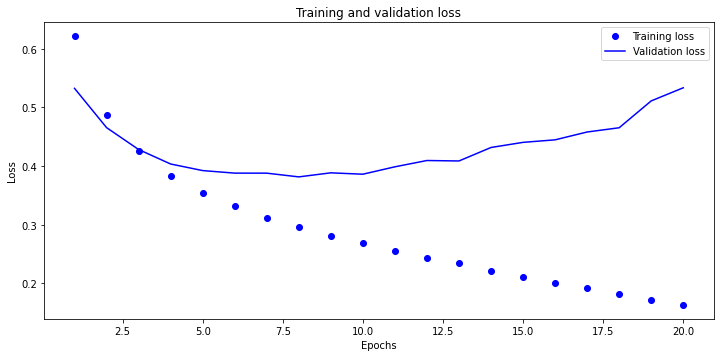

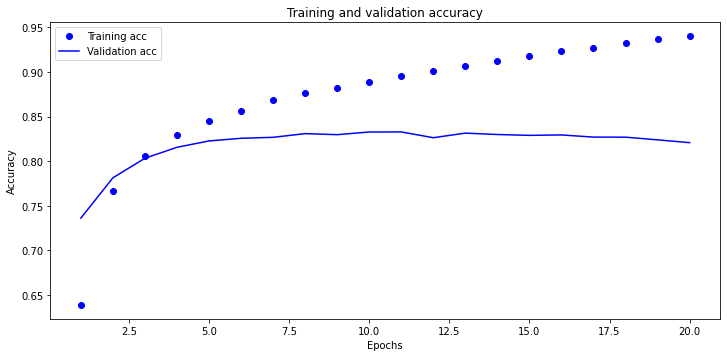

In [178]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 전보단느 확실히 개선되었다. 그래도 여전히 엉망임.